# Library imports

It'd be good if you could get 500 GB of mem.

In [1]:
import xarray as xr 
import glob 
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.optimize import curve_fit
import cftime

import numpy as np
import copy
import os 
import sys 
import matplotlib.pyplot as plt 
import glob
import pickle
import pandas as pd

import cartopy.crs as ccrs

from sklearn.preprocessing import QuantileTransformer
from functools import lru_cache

import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

from scipy.optimize import linear_sum_assignment
from PIL import Image
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# from eofs.xarray import Eof

import torch
from typing import Dict
from credit.physics_constants import RAD_EARTH, GRAVITY
from credit.physics_constants import RAD_EARTH, GRAVITY

import glob

from torch import nn
import numpy as np
import os

from credit.data import get_forward_data
from credit.transforms import load_transforms
from credit.physics_core import physics_pressure_level, physics_hybrid_sigma_level
from credit.physics_constants import (
    GRAVITY,
    RHO_WATER,
    LH_WATER,
    CP_DRY,
    CP_VAPOR,
)
from credit.postblock import GlobalEnergyFixer

import logging
import yaml
from credit.parser import credit_main_parser, predict_data_check
from dask.distributed import Client, get_client
import time

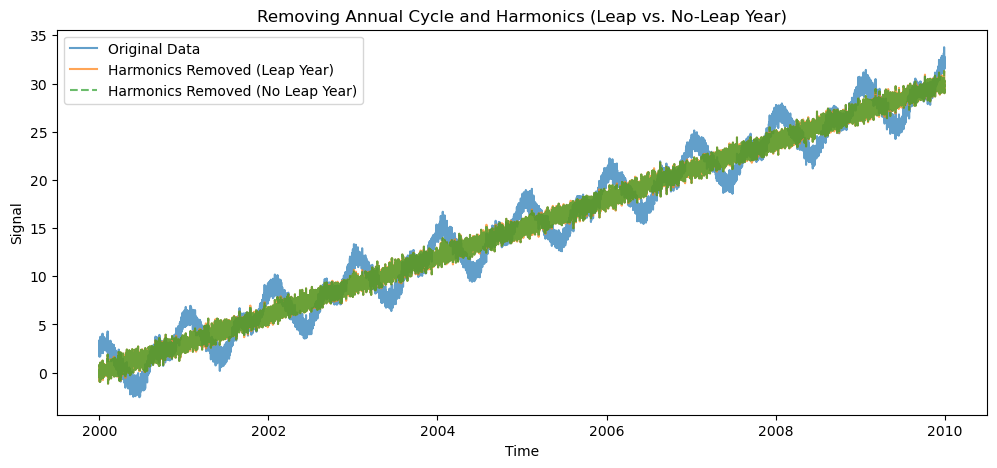

In [2]:
def smooth_1d_array(data, window_size):
    """
    Apply a moving average smoothing filter to a 1D numpy array.

    Parameters:
    -----------
    data : np.ndarray
        The 1D array to smooth.
    window_size : int
        The size of the moving window (number of time steps).

    Returns:
    --------
    np.ndarray
        The smoothed array, with the same length as the input array.
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if len(data) < window_size:
        raise ValueError("Data length must be greater than or equal to the window size.")

    # Pad the array to handle edge effects
    padded_data = np.pad(data, pad_width=(window_size // 2,), mode='reflect')

    # Apply convolution for smoothing
    smoothed_data = np.convolve(padded_data, np.ones(window_size) / window_size, mode='valid')

    return smoothed_data


def compute_fractional_years(time_values, days_per_year=365.25):
    """
    Converts time values (CFTime or datetime64) into fractional years relative to the first timestamp.
    
    Parameters:
    -----------
    time_values : array-like
        Array of time values (CFTime or datetime64).
    days_per_year : float, optional
        Number of days per year (365.25 for leap years, 365 for no-leap).
    
    Returns:
    --------
    np.ndarray
        Array of fractional years.
    """
    time_start = time_values[0]  # First time point (reference)
    
    if isinstance(time_start, cftime.datetime):  # If CFTime
        time_numeric = np.array([
            (t.year - time_start.year) + (t.timetuple().tm_yday - time_start.timetuple().tm_yday) / days_per_year
            for t in time_values
        ])
    else:  # If NumPy datetime64 (standard)
        time_numeric = (time_values - time_start) / np.timedelta64(1, 'D') / days_per_year

    return time_numeric



def remove_annual_harmonics(ds, time_resolution="6h", keep_mean_slope=True, leap_year=True):
    """
    Removes the annual cycle and the first six harmonics using harmonic regression.

    Parameters:
    -----------
    ds : xarray.DataArray
        The input time series data with a 'time' coordinate.
    time_resolution : str, optional
        The time resolution (default is "6H" for 6-hourly data).
    keep_mean_slope : bool, optional
        If True, retains the mean and slope of the original data.
    leap_year : bool, optional
        If True, assumes 365.25 days per year (accounts for leap years).
        If False, assumes 365 days per year (ignores leap years).
        
    Returns:
    --------
    xarray.DataArray
        The detrended and de-harmonicized data.
    """
    # Ensure 'time' is a coordinate
    if 'time' not in ds.coords:
        raise ValueError("Dataset must have a 'time' coordinate.")

    # Set the correct days per year
    days_per_year = 365.25 if leap_year else 365.0

    # Convert 'time' coordinate into fractional years
    # time_start = ds.time.values[0]
    # time_numeric = np.array([(t - time_start) / np.timedelta64(1, 'D') / days_per_year for t in ds.time.values])

    time_numeric = compute_fractional_years(ds.time)

    # Define harmonic function with six harmonics
    def harmonic_model(t, *params):
        """ Harmonic regression model with six harmonics """
        a0, b0 = params[:2]  # Intercept and linear trend
        harmonics = 0
        for i in range(1, 7):
            ai, bi = params[2*i], params[2*i + 1]
            harmonics += ai * np.cos(2 * np.pi * i * t) + bi * np.sin(2 * np.pi * i * t)
        return a0 + b0 * t + harmonics

    # Initial parameter guesses (zeros)
    p0 = np.zeros(14)  # 2 (mean/trend) + 6 harmonics * 2 (cos/sin)

    # Perform harmonic regression
    def fit_and_remove(time_vals, data_vals):
        """ Fit harmonic model and remove harmonics """
        valid = ~np.isnan(data_vals)
        if valid.sum() < 14:  # Ensure enough data points
            return data_vals  # Return original if too few points
        
        # Fit model
        params, _ = curve_fit(harmonic_model, time_vals[valid], data_vals[valid], p0=p0)
        
        # Compute harmonic signal
        harmonic_signal = harmonic_model(time_vals, *params)
        
        # Remove harmonics but keep trend if requested
        if keep_mean_slope:
            return data_vals - (harmonic_signal - (params[0] + params[1] * time_vals))
        else:
            return data_vals - harmonic_signal

    # Apply function along the time axis
    detrended_ds = xr.apply_ufunc(
        fit_and_remove,
        xr.DataArray(time_numeric, dims="time", coords={"time": ds.time}),
        ds,
        input_core_dims=[["time"], ["time"]],
        output_core_dims=[["time"]],
        vectorize=True
    )
    
    return detrended_ds

# --- TESTING WITH LEAP YEAR AND NO-LEAP YEAR CASES ---

# Create synthetic dataset
time_range = pd.date_range("2000-01-01", "2010-01-01", freq="6h")
n_time = len(time_range)

# Create synthetic signal: annual cycle + harmonics + trend
years = (time_range - time_range[0]) / np.timedelta64(1, 'D') / 365  # Using 365 to match no-leap year option
signal = (
    2 * np.cos(2 * np.pi * years) +  # Annual cycle
    1 * np.sin(4 * np.pi * years) +  # 1st harmonic
    0.5 * np.cos(6 * np.pi * years) +  # 2nd harmonic
    3 * years +  # Linear trend
    np.random.normal(scale=0.5, size=n_time)  # Noise
)

# Convert to xarray DataArray
ds = xr.DataArray(signal, dims="time", coords={"time": time_range}, name="synthetic_climate_data")

# Apply function with leap year correction
detrended_ds_leap = remove_annual_harmonics(ds, leap_year=True)

# Apply function without leap year correction
detrended_ds_no_leap = remove_annual_harmonics(ds, leap_year=False)

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(ds.time, ds, label="Original Data", alpha=0.7)
plt.plot(detrended_ds_leap.time, detrended_ds_leap, label="Harmonics Removed (Leap Year)", alpha=0.7)
plt.plot(detrended_ds_no_leap.time, detrended_ds_no_leap, label="Harmonics Removed (No Leap Year)", alpha=0.7, linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()
plt.title("Removing Annual Cycle and Harmonics (Leap vs. No-Leap Year)")
plt.show()


## Data Gather

In [3]:
# # Get the current client if one exists and close it
try:
    client = get_client()
    client.close()
except ValueError:
    print("No active client found.")

client = Client()
print(f"Dask dashboard available at: {client.dashboard_link}")
time.sleep(19)  # Sleeps for 1 second

No active client found.
Dask dashboard available at: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/Grow/proxy/8787/status


In [4]:
%%time
conc = []
for yryr in range(1979,2014):
    print(f'doing {yryr}')
    DSdo_1 = xr.open_zarr(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_{yryr}_ERA5scaled_F32_Qtot.zarr')
    conc.append(DSdo_1)

print('... resampling and loading ....')
DSzarr1 = xr.concat(conc, dim='time')
DSzarr1_TP = DSzarr1[['TREFHT','PS','Qtot','T']].isel(level=slice(0,32)).resample(time='1D').mean().load()
print('... resampled and loaded ....')

doing 1979
doing 1980
doing 1981
doing 1982
doing 1983
doing 1984
doing 1985
doing 1986
doing 1987
doing 1988
doing 1989
doing 1990
doing 1991
doing 1992
doing 1993
doing 1994
doing 1995
doing 1996
doing 1997
doing 1998
doing 1999
doing 2000
doing 2001
doing 2002
doing 2003
doing 2004
doing 2005
doing 2006
doing 2007
doing 2008
doing 2009
doing 2010
doing 2011
doing 2012
doing 2013
... resampling and loading ....


/glade/work/wchapman/conda-envs/credit-dk-casper/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 34.43 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


... resampled and loaded ....
CPU times: user 5min 58s, sys: 1min 43s, total: 7min 41s
Wall time: 8min 2s


## Open the Ensembles:

In [ ]:
%%time
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-02T00Z_OG/1D/averaged_UVTQtotPSPRECTTREFHT*'))
print('... opening model run ...')
DSs_00 = xr.open_mfdataset(FNS)
DSs_00 = DSs_00.isel(level=slice(0,32))

FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-01T00Z_OG/1D/averaged_UVTQtotPSPRECTTREFHT*'))
print('... opening model run ...')
DSs_01 = xr.open_mfdataset(FNS)
DSs_01 = DSs_01.isel(level=slice(0,32))

FNS = sorted(glob.glob('/glade/campaign/cisl/aiml/wchapman/CAMulator_analysis/prescribed_skebs_feb_14/1D/averaged_QtotPSTREFHT_????-??_1D.nc'))
print('... opening model run ...')
Dens_01 = xr.open_mfdataset(FNS)
Dens_01 = Dens_01.isel(level=slice(0,32))

FNS = sorted(glob.glob('/glade/campaign/cisl/aiml/wchapman/CAMulator_analysis/prescribed_skebs_rollout_2/1D/averaged_QtotPSTREFHT_????-??_1D.nc'))
print('... opening model run ...')
Dens_02 = xr.open_mfdataset(FNS)
Dens_02 = Dens_02.isel(level=slice(0,32))

DSzarr1_TP['level']=DSzarr1['level']
DSs_00['level']=DSzarr1['level']
DSs_01['level']=DSzarr1['level']
Dens_01['level']=DSzarr1['level']
Dens_02['level']=DSzarr1['level']

## T in the Lowest Model level

In [ ]:
%%time
# Calculate latitude weights (cosine of latitude in radians)
weights = np.cos(np.deg2rad(DSs_00['latitude']))

# Normalize weights to sum to 1
weights /= weights.sum()

# Apply latitude weighting to the mean (resampled daily)
weighted_mean_camulator00= (DSs_00['TREFHT']
                      .weighted(weights)
                      .mean(dim=['longitude', 'latitude'], skipna=True))

# Apply latitude weighting to the mean (resampled daily)
weighted_mean_camulator01= (DSs_01['TREFHT']
                      .weighted(weights)
                      .mean(dim=['longitude', 'latitude'], skipna=True))

# Apply latitude weighting to the mean (resampled daily)
weighted_mean_camulator02= (Dens_01['TREFHT']
                      .weighted(weights)
                      .mean(dim=['longitude', 'latitude'], skipna=True))

# Apply latitude weighting to the mean (resampled daily)
weighted_mean_camulator03= (Dens_02['TREFHT']
                      .weighted(weights)
                      .mean(dim=['longitude', 'latitude'], skipna=True))

# Calculate latitude weights (cosine of latitude in radians)
weights = np.cos(np.deg2rad(DSzarr1['latitude']))

# Normalize weights to sum to 1
weights /= weights.sum()

# Apply latitude weighting to the mean (without resampling)
weighted_mean1_cam = (DSzarr1_TP['TREFHT']
                 .weighted(weights)
                 .mean(dim=['longitude', 'latitude'], skipna=True))
weighted_mean_camulator00 = weighted_mean_camulator00.to_dataset(name='T').load()
weighted_mean_camulator01 = weighted_mean_camulator01.to_dataset(name='T').load()
weighted_mean_camulator02 = weighted_mean_camulator02.to_dataset(name='T').load()
weighted_mean_camulator03 = weighted_mean_camulator03.to_dataset(name='T').load()

weighted_mean1_cam = weighted_mean1_cam.to_dataset(name='T').load()

In [ ]:
import matplotlib.pyplot as plt
TT_cam = remove_annual_harmonics(weighted_mean1_cam, leap_year=False)
TT_camulator00 = remove_annual_harmonics(weighted_mean_camulator00, leap_year=False)
TT_camulator01 = remove_annual_harmonics(weighted_mean_camulator01, leap_year=False)
TT_camulator02 = remove_annual_harmonics(weighted_mean_camulator02, leap_year=False)
TT_camulator03 = remove_annual_harmonics(weighted_mean_camulator03, leap_year=False)


# Convert cftime to datetime
time_converted = [t.strftime('%Y-%m-%d') for t in weighted_mean1_cam['time'].values]

# Extract indices for January 1 of each year
year_ticks = [i for i, t in enumerate(weighted_mean1_cam['time'].values) if t.month == 1 and t.day == 1]

# Create the plot
plt.figure(figsize=(19, 8))  # Larger figure for better visibility


plt.plot(smooth_1d_array(TT_cam['T'].values, 90),label='CAM',
    color='purple',
    linewidth=2
)

plt.plot(smooth_1d_array(TT_camulator00['T'].values, 90),label='CAMulator',
    color='teal',
    linewidth=2, alpha=0.15
)

for ii in range(12):
    plt.plot(smooth_1d_array(TT_camulator02['T'].values.T[:,ii], 90),
        color='teal',
        linewidth=2, alpha=0.15
    )

for ii in range(12):
    plt.plot(smooth_1d_array(TT_camulator03['T'].values.T[:,ii], 90),
        color='teal',
        linewidth=2, alpha=0.15
    )


plt.plot(smooth_1d_array(TT_camulator01['T'].values, 90),
    color='teal',
    linewidth=2, alpha=0.15
)

# Customize x-axis ticks to show years
plt.xticks(
    year_ticks[::2],
    [time_converted[i] for i in year_ticks][::2],
    rotation=45,
    fontsize=13  # Smaller font size for clarity
)
plt.yticks(fontsize=15)


# Adjust x-axis limits and labels
# plt.xlim([0, 5110])  # Limit the x-axis range
plt.xlabel("Time (Year)", fontsize=15)
plt.ylabel("T2M [K]", fontsize=15)

# Add legend with improved styling
plt.legend(
    loc='upper left',
    fontsize=14,
    frameon=True,
    fancybox=True,
    shadow=True
)
plt.show()

## 2000 case rollout

In [ ]:
base_dir = '/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/'
FNS1 = sorted(glob.glob(f"{base_dir}/monthly/1980-01-01T00Z/pred*.nc"))
FNS2 = sorted(glob.glob(f"{base_dir}/monthly_01/2102-01-01T00Z/pred*.nc"))
FNS = (FNS1+FNS2)

## here we go: 
DS2 = xr.open_mfdataset(FNS2[:-5], parallel=True)
DS1 = xr.open_mfdataset(FNS1[2:], parallel=True)
DS2['time'] = DS2['time'].astype('datetime64[ns]') - np.timedelta64(365, 'D')
DS1['time'] = DS1['time'].astype('datetime64[ns]')
DS = xr.concat([DS1,DS2],dim='time')

In [ ]:
%%time
# Calculate latitude weights (cosine of latitude in radians)
weights = np.cos(np.deg2rad(DS['latitude']))

# Normalize weights to sum to 1
weights /= weights.sum()
weights = weights.load()

# Apply latitude weighting to the mean
weighted_month = (DS['TREFHT']
                      .weighted(weights)
                      .mean(['longitude', 'latitude']))
weighted_month.load()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from scipy.stats import linregress

# Define selected 30-year periods
start_years = [1981, 2011, 2041, 2071, 2111]  # Evenly spaced 30-year segments
periods = [(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year+31}-12-31")) for year in start_years]

# Extract the selected time periods
selected_times = np.concatenate([weighted_month['time'].sel(time=slice(start, end)).values for start, end in periods])
selected_values = np.concatenate([weighted_month.sel(time=slice(start, end)).values for start, end in periods])

# Compute the trend over the whole period
start_years = [1981, 2011, 2041, 2071]  # Evenly spaced 30-year segments
periods = [(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year+30}-12-31")) for year in start_years]

time = weighted_month['time'].to_index()[10:]
slope, intercept, _, _, _ = linregress(time.map(pd.Timestamp.toordinal), weighted_month[10:].values)
trend_line = intercept + slope * time.map(pd.Timestamp.toordinal)

# Plotting
fig, ax = plt.subplots(figsize=(19, 8))

# Plot selected time periods
ax.plot(weighted_month['time'][10:], weighted_month[10:], label="CAMulator", color="tab:blue", alpha=0.7)

# Plot trend over full dataset
ax.plot(weighted_month['time'][10:], trend_line, color="black", linestyle="--", label="Long-Term Trend")

# # Indicate time gaps with vertical dashed lines
# for end in start_years:  # Skip last since there's no gap after it
#     ax.axvline(end, color="gray", linestyle="dashed", alpha=0.6)

ax.grid(True, alpha =0.3)
# Labels and title
ax.set_ylabel("[K]", fontsize=15)
ax.set_title("T2M 2000-Clim",fontsize=22)
ax.tick_params(axis='x', labelsize=13)  # Adjust x-axis tick label size
ax.tick_params(axis='y', labelsize=13)  # Optionally adjust y-axis tick label size
ax.legend(fontsize=13)
plt.xlim([3455,85000])
plt.show()


# Combine the Figures:

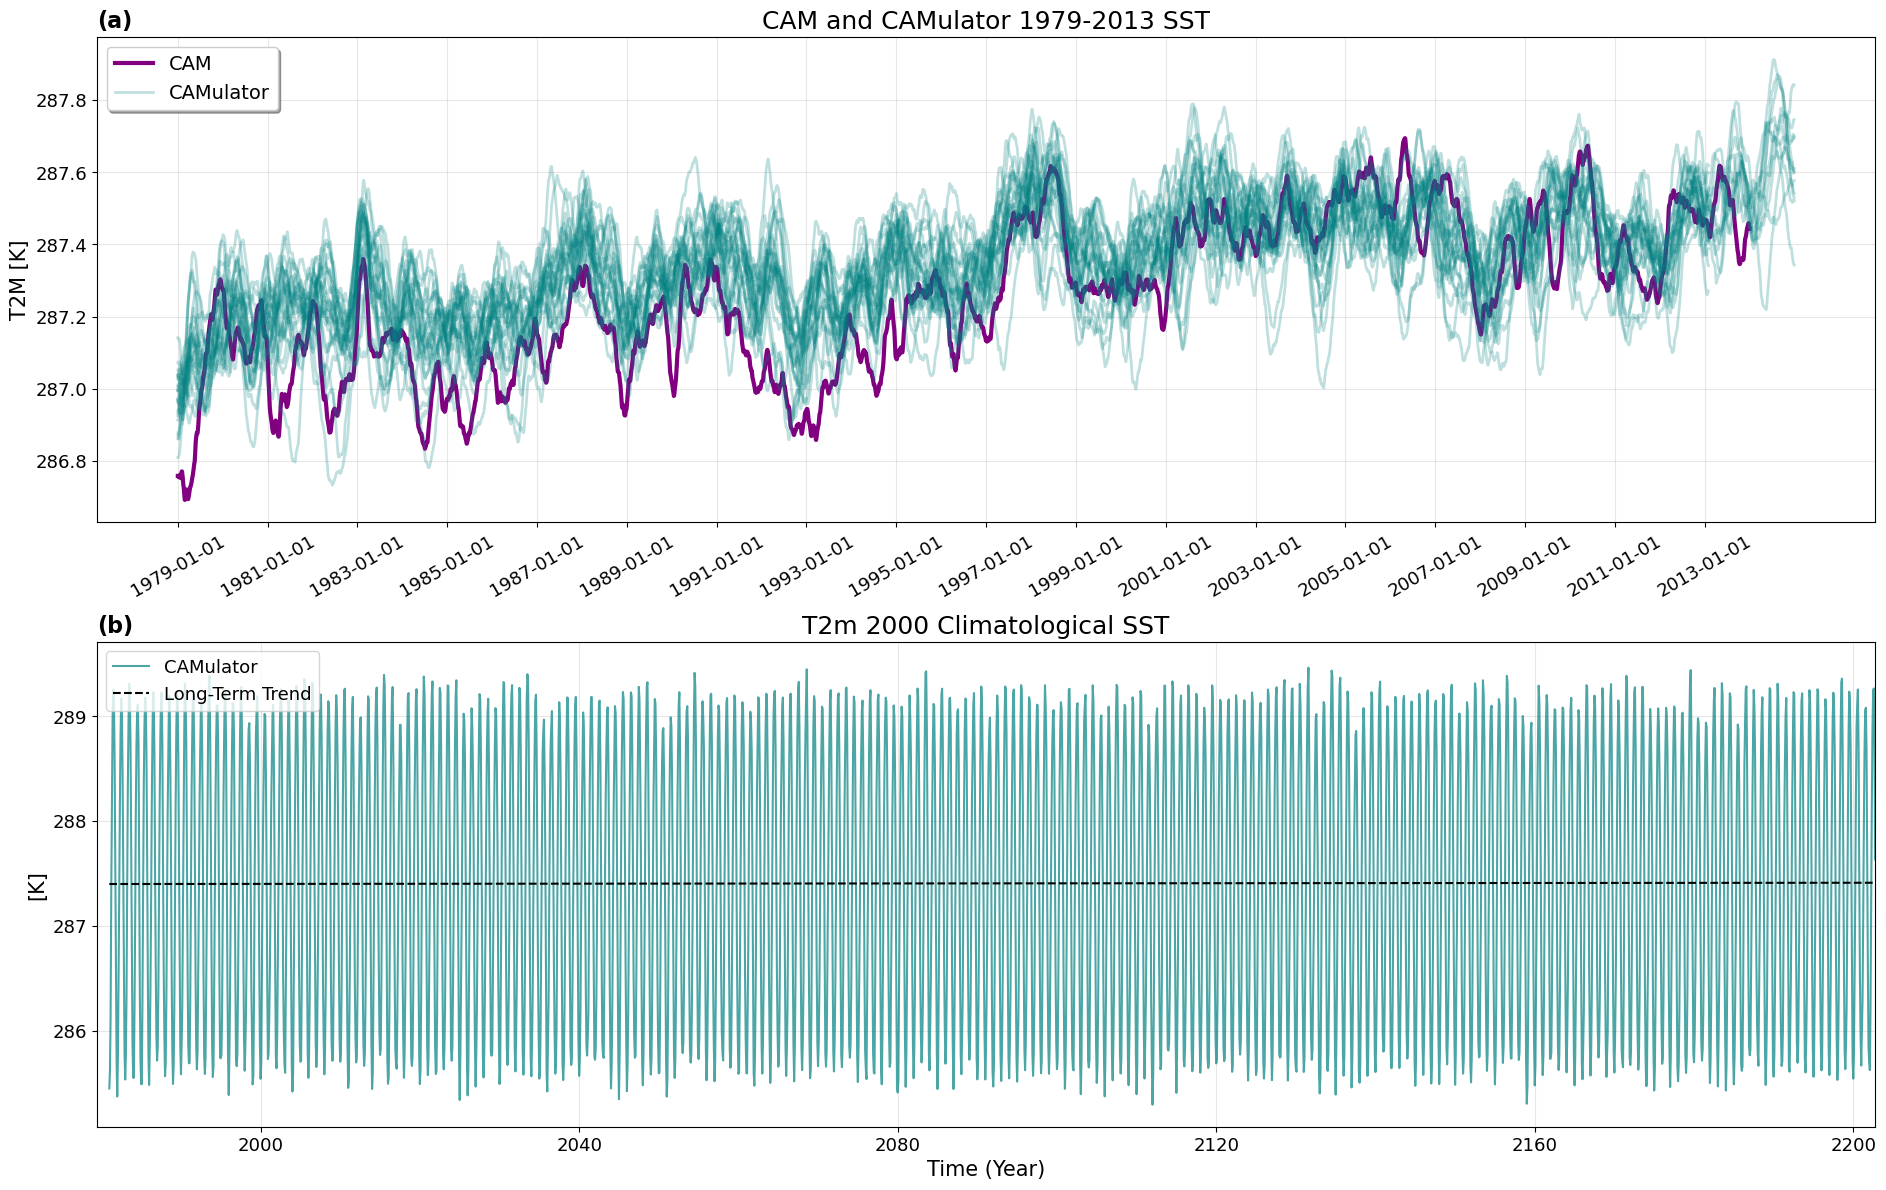

In [18]:
# Creating a stacked figure with two panels

# Convert cftime to datetime
time_converted = [t.strftime('%Y-%m-%d') for t in weighted_mean1_cam['time'].values]

# Extract indices for January 1 of each year
year_ticks = [i for i, t in enumerate(weighted_mean1_cam['time'].values) if t.month == 1 and t.day == 1]


fig, axes = plt.subplots(nrows=2, figsize=(19, 12), sharex=False, gridspec_kw={'height_ratios': [1, 1]})

# Panel 1: Smoothed CAM and CAMulator Data
ax1 = axes[0]
ax1.plot(smooth_1d_array(TT_cam['T'].values, 90), label='CAM', color='purple', linewidth=3)

ax1.plot(smooth_1d_array(TT_camulator00['T'].values, 90), label='CAMulator', color='teal', linewidth=2, alpha=0.25)

for ii in range(12):
    ax1.plot(smooth_1d_array(TT_camulator02['T'].values.T[:, ii], 90), color='teal', linewidth=2, alpha=0.25)
    ax1.plot(smooth_1d_array(TT_camulator03['T'].values.T[:, ii], 90), color='teal', linewidth=2, alpha=0.25)

ax1.plot(smooth_1d_array(TT_camulator01['T'].values, 90), color='teal', linewidth=2, alpha=0.25)

# x-axis adjustments
ax1.set_ylabel("T2M [K]", fontsize=15)
ax1.legend(loc='upper left', fontsize=14, frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.3)
ax1.set_title("CAM and CAMulator 1979-2013 SST", fontsize=18)

# Customize x-axis ticks to show years
ax1.set_xticks(
    year_ticks[::2],
    [time_converted[i] for i in year_ticks][::2],
    rotation=30,
    fontsize=13  # Smaller font size for clarity
)
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
ax1.text(0.0, 1.02, "(a)", transform=ax1.transAxes, fontsize=16, fontweight="bold")


# Panel 2: Weighted Monthly Global Mean Temperature
ax2 = axes[1]
ax2.plot(weighted_month['time'][10:], weighted_month[10:], label="CAMulator", color="teal", alpha=0.7)
ax2.plot(weighted_month['time'][10:], trend_line, color="black", linestyle="--", label="Long-Term Trend")

ax2.set_xlabel("Time (Year)", fontsize=15)
ax2.set_ylabel("[K]", fontsize=15)
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
ax2.set_xlim([3455, 85000])  # Matching x-axis range
ax2.legend(loc='upper left', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.set_title("T2m 2000 Climatological SST", fontsize=18)
ax2.text(0.0, 1.02, "(b)", transform=ax2.transAxes, fontsize=16, fontweight="bold")

# Show the figure
plt.tight_layout()
plt.savefig('Temperature_Trend_Static.png',dpi=250, bbox_inches='tight')
plt.show()


## Tropospheric Water Path and total Tint

In [9]:
def pressure_integral_midpoint_slice(q_mid: xr.DataArray, 
                               surface_pressure: xr.DataArray, 
                               coef_a: xr.DataArray, 
                               coef_b: xr.DataArray,
                               sl_h: float,
                               sl_l: float) -> xr.DataArray:
    """
    Compute the pressure level integral of a given quantity; assuming its mid-point
    values are pre-computed.

    Args:
        q_mid (xr.DataArray): The quantity with dims of ('batch', 'level', 'time', 'lat', 'lon').
        surface_pressure (xr.DataArray): Surface pressure in Pa ('batch', 'time', 'lat', 'lon').
        coef_a (xr.DataArray): Coefficient a for pressure computation ('level',).
        coef_b (xr.DataArray): Coefficient b for pressure computation ('level',).

    Returns:
        xr.DataArray: Pressure level integrals of q.
    """

    # Ensure surface pressure has the correct dimensions
    surface_pressure = surface_pressure.expand_dims(dim={"ilev": coef_a.sizes["ilev"]}, axis=1)

    # Compute pressure at each level
    pressure = coef_a + coef_b * surface_pressure

    # Compute delta pressure (pressure difference between levels)
    delta_p = pressure.diff(dim="ilev")
    delta_p = delta_p.rename({'ilev':'level'})
    delta_p['level'] = q_mid['level']

    # Element-wise multiplication
    q_area = q_mid * delta_p

    # Sum over the 'level' dimension
    q_integral = q_area.sel(level=slice(sl_h,sl_l)).sum(dim="level")

    return q_integral

## Total Integrated T

In [7]:
model_level_file = '/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.statics_1.0deg_32levs_latlon_F32_hyai.nc'
DSml = xr.open_dataset(model_level_file)
print('starting')
# Define time chunk size
time_chunk = 1000
num_time_points = len(DSzarr1_TP['time'])
all_results = []

# Loop over time chunks
for start in range(0, num_time_points, time_chunk):
    end = min(start + time_chunk, num_time_points)
    print(f'Processing time points {start} to {end}')

    Qint_chunk = pressure_integral_midpoint_slice(
        DSzarr1_TP['T'].isel(time=slice(start, end)),
        DSzarr1_TP['PS'].isel(time=slice(start, end)),
        DSml['hyai'],
        DSml['hybi'],
        sl_h=0,
        sl_l=1000
    )

    all_results.append(Qint_chunk)

# Concatenate all chunks along the time dimension
Qint_final = xr.concat(all_results, dim='time')

print('Processing complete')

# Compute weighted mean
weights = np.cos(np.deg2rad(Qint_final['latitude']))
weights /= weights.sum()
weighted_Qint_final = Qint_final.weighted(weights).mean(['longitude', 'latitude'])

print('Weighted mean computation complete')
weighted_Qint_final.to_netcdf('./Tint_cam_1979_2014.nc')

starting
Processing time points 0 to 1000
Processing time points 1000 to 2000
Processing time points 2000 to 3000
Processing time points 3000 to 4000
Processing time points 4000 to 5000
Processing time points 5000 to 6000
Processing time points 6000 to 7000
Processing time points 7000 to 8000
Processing time points 8000 to 9000
Processing time points 9000 to 10000
Processing time points 10000 to 11000
Processing time points 11000 to 12000
Processing time points 12000 to 12775
Processing complete
Weighted mean computation complete


In [5]:
%%time
FNS = sorted(glob.glob('/glade/campaign/cisl/aiml/wchapman/CAMulator_analysis/prescribed_skebs_feb_14_T/1D/averaged_PST_????-??_1D.nc'))
print('... opening model run ...')
Dens_01 = xr.open_mfdataset(FNS)
Dens_01 = Dens_01.isel(level=slice(0,32))

FNS = sorted(glob.glob('/glade/campaign/cisl/aiml/wchapman/CAMulator_analysis/prescribed_skebs_rollout_2_T/1D/averaged_PST_????-??_1D.nc'))
print('... opening model run ...')
Dens_02 = xr.open_mfdataset(FNS)
Dens_02 = Dens_02.isel(level=slice(0,32))

DSzarr1_TP['level']=DSzarr1['level']
Dens_01['level']=DSzarr1['level']
Dens_02['level']=DSzarr1['level']

... opening model run ...
... opening model run ...
CPU times: user 12.4 s, sys: 3.86 s, total: 16.2 s
Wall time: 52.8 s


In [10]:
%%time
# Load dataset
model_level_file = '/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.statics_1.0deg_32levs_latlon_F32_hyai.nc'
DSml = xr.open_dataset(model_level_file)

print('Starting processing ensembles in chunks')

# Define time chunk size
time_chunk = 1500
ensemble_labels = Dens_01['ensemble_member_label'].values  # Get ensemble labels
all_ensemble_results = []

for ens in ensemble_labels:
    print(f'Processing ensemble {ens}')
    num_time_points = len(Dens_01['time'])
    all_results = []

    # Process chunks for each ensemble
    for start in range(0, num_time_points, time_chunk):
        end = min(start + time_chunk, num_time_points)
        print(f'Processing time points {start} to {end} for ensemble {ens}')

        # Load a single ensemble and the time chunk into memory
        BB = Dens_01.sel(ensemble_member_label=ens).isel(time=slice(start, end)).load()
        print('Loaded chunk')

        # Compute integral
        Qint_chunk = pressure_integral_midpoint_slice(
            BB['T'],
            BB['PS'],
            DSml['hyai'],
            DSml['hybi'],
            sl_h=0,
            sl_l=1000
        )

        all_results.append(Qint_chunk.load())

    # Concatenate all chunks for the current ensemble
    Qint_final_ens = xr.concat(all_results, dim='time')
    all_ensemble_results.append(Qint_final_ens)

    print(f'Finished processing ensemble {ens}')

# Concatenate all ensemble results
Qint_final_all_ens = xr.concat(all_ensemble_results, dim='ensemble_member_label')

print('Processing complete for all ensembles')

# Compute weighted mean
weights = np.cos(np.deg2rad(Qint_final_all_ens['latitude']))
weights /= weights.sum()
weighted_Qint_final_all_ens = Qint_final_all_ens.weighted(weights).mean(['longitude', 'latitude'])

print('Weighted mean computation complete')
weighted_Qint_final_all_ens = weighted_Qint_final_all_ens.load()
weighted_Qint_final_all_ens.to_netcdf('./Tint_camulator_ensemble_1979_2014_01.nc')


Starting processing ensembles in chunks
Processing ensemble 0
Processing time points 0 to 1500 for ensemble 0
Loaded chunk
Processing time points 1500 to 3000 for ensemble 0
Loaded chunk
Processing time points 3000 to 4500 for ensemble 0
Loaded chunk
Processing time points 4500 to 6000 for ensemble 0
Loaded chunk
Processing time points 6000 to 7500 for ensemble 0
Loaded chunk
Processing time points 7500 to 9000 for ensemble 0
Loaded chunk
Processing time points 9000 to 10500 for ensemble 0
Loaded chunk
Processing time points 10500 to 12000 for ensemble 0
Loaded chunk
Processing time points 12000 to 13125 for ensemble 0
Loaded chunk
Finished processing ensemble 0
Processing ensemble 1
Processing time points 0 to 1500 for ensemble 1
Loaded chunk
Processing time points 1500 to 3000 for ensemble 1
Loaded chunk
Processing time points 3000 to 4500 for ensemble 1
Loaded chunk
Processing time points 4500 to 6000 for ensemble 1
Loaded chunk
Processing time points 6000 to 7500 for ensemble 1
Loa

In [11]:
%%time
# Load dataset
model_level_file = '/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.statics_1.0deg_32levs_latlon_F32_hyai.nc'
DSml = xr.open_dataset(model_level_file)

print('Starting processing ensembles in chunks')

# Define time chunk size
time_chunk = 1500
ensemble_labels = Dens_02['ensemble_member_label'].values  # Get ensemble labels
all_ensemble_results = []

for ens in ensemble_labels:
    print(f'Processing ensemble {ens}')
    num_time_points = len(Dens_02['time'])
    all_results = []

    # Process chunks for each ensemble
    for start in range(0, num_time_points, time_chunk):
        end = min(start + time_chunk, num_time_points)
        print(f'Processing time points {start} to {end} for ensemble {ens}')

        # Load a single ensemble and the time chunk into memory
        BB = Dens_02.sel(ensemble_member_label=ens).isel(time=slice(start, end)).load()
        print('Loaded chunk')

        # Compute integral
        Qint_chunk = pressure_integral_midpoint_slice(
            BB['T'],
            BB['PS'],
            DSml['hyai'],
            DSml['hybi'],
            sl_h=0,
            sl_l=1000
        )

        all_results.append(Qint_chunk.load())

    # Concatenate all chunks for the current ensemble
    Qint_final_ens = xr.concat(all_results, dim='time')
    all_ensemble_results.append(Qint_final_ens)

    print(f'Finished processing ensemble {ens}')

# Concatenate all ensemble results
Qint_final_all_ens = xr.concat(all_ensemble_results, dim='ensemble_member_label')

print('Processing complete for all ensembles')

# Compute weighted mean
weights = np.cos(np.deg2rad(Qint_final_all_ens['latitude']))
weights /= weights.sum()
weighted_Qint_final_all_ens = Qint_final_all_ens.weighted(weights).mean(['longitude', 'latitude'])

print('Weighted mean computation complete')
weighted_Qint_final_all_ens = weighted_Qint_final_all_ens.load()
weighted_Qint_final_all_ens.to_netcdf('./Tint_camulator_ensemble_1979_2014_02.nc')


Starting processing ensembles in chunks
Processing ensemble 0
Processing time points 0 to 1500 for ensemble 0
Loaded chunk
Processing time points 1500 to 3000 for ensemble 0
Loaded chunk
Processing time points 3000 to 4500 for ensemble 0
Loaded chunk
Processing time points 4500 to 6000 for ensemble 0
Loaded chunk
Processing time points 6000 to 7500 for ensemble 0
Loaded chunk
Processing time points 7500 to 9000 for ensemble 0
Loaded chunk
Processing time points 9000 to 10500 for ensemble 0
Loaded chunk
Processing time points 10500 to 12000 for ensemble 0
Loaded chunk
Processing time points 12000 to 13096 for ensemble 0
Loaded chunk
Finished processing ensemble 0
Processing ensemble 1
Processing time points 0 to 1500 for ensemble 1
Loaded chunk
Processing time points 1500 to 3000 for ensemble 1
Loaded chunk
Processing time points 3000 to 4500 for ensemble 1
Loaded chunk
Processing time points 4500 to 6000 for ensemble 1
Loaded chunk
Processing time points 6000 to 7500 for ensemble 1
Loa

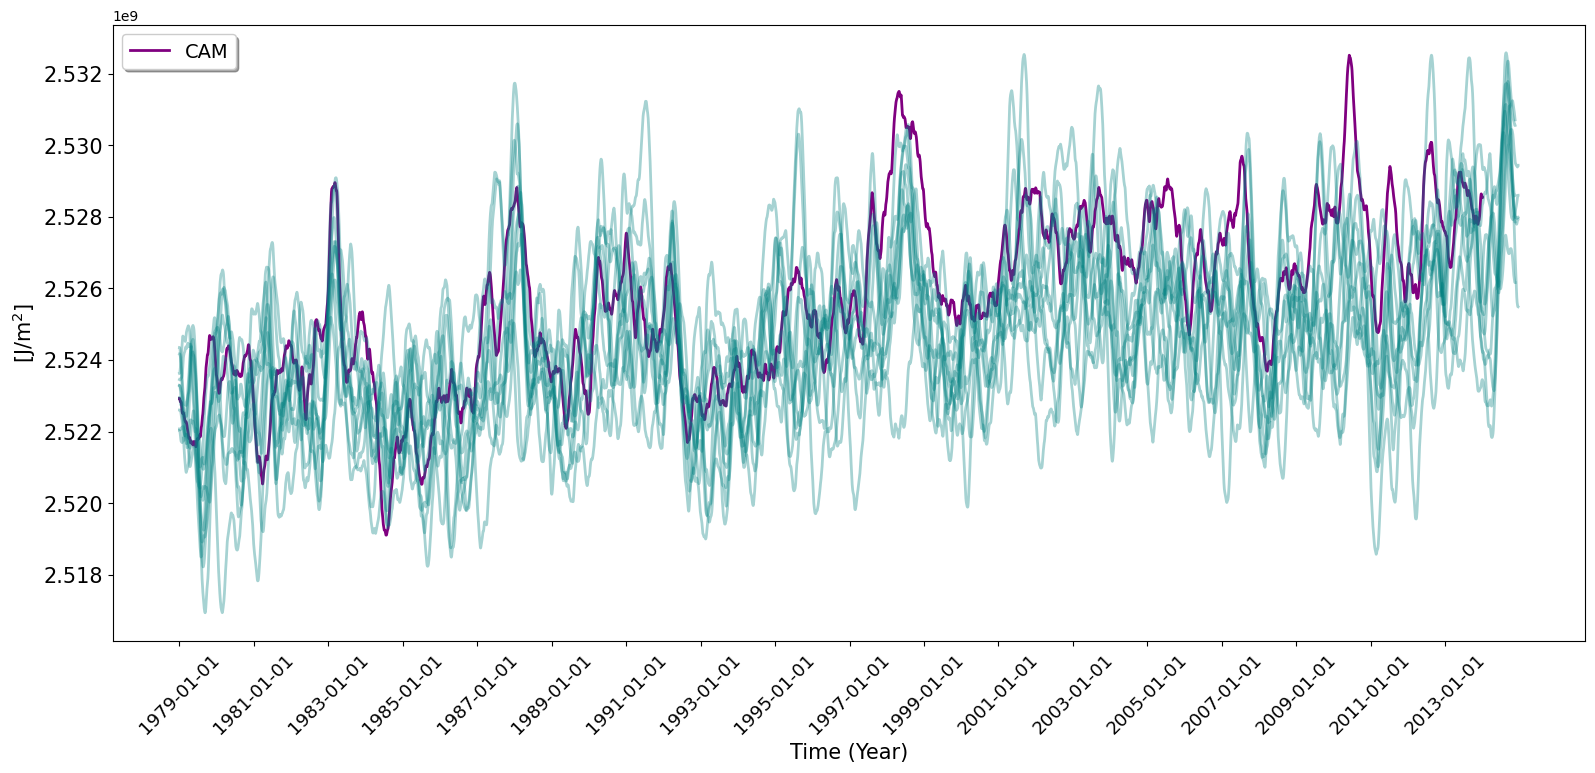

In [17]:
import matplotlib.pyplot as plt

weighted_Qint_final_all_ens_01 = xr.open_dataset('./Tint_camulator_ensemble_1979_2014_01.nc')
weighted_Qint_final_all_ens_02 = xr.open_dataset('./Tint_camulator_ensemble_1979_2014_02.nc')
weighted_Qint_final = xr.open_dataset('./Tint_cam_1979_2014.nc')

TWP_cam = remove_annual_harmonics(weighted_Qint_final, leap_year=False)
TWP_camulator01 = remove_annual_harmonics(weighted_Qint_final_all_ens_01, leap_year=False)
TWP_camulator02 = remove_annual_harmonics(weighted_Qint_final_all_ens_02, leap_year=False)

#divide by gravity and multiply by cp for total heat content. J / m2
# Convert cftime to datetime
time_converted = [t.strftime('%Y-%m-%d') for t in weighted_Qint_final['time'].values]

# Extract indices for January 1 of each year
year_ticks = [i for i, t in enumerate(weighted_Qint_final['time'].values) if t.month == 1 and t.day == 1]

# Create the plot
plt.figure(figsize=(19, 8))  # Larger figure for better visibility


plt.plot(smooth_1d_array(1004*(TWP_cam['__xarray_dataarray_variable__'].values/9.81), 90),label='CAM',
    color='purple',
    linewidth=2
)

for ii in range(5):
    plt.plot(smooth_1d_array(1004*(TWP_camulator02['__xarray_dataarray_variable__'].values.T[:,ii]/9.81), 90),
        color='teal',
        linewidth=2, alpha=0.35
    )


for ii in range(5):
    plt.plot(smooth_1d_array(1004*(TWP_camulator01['__xarray_dataarray_variable__'].values.T[:,ii]/9.81), 90),
        color='teal',
        linewidth=2, alpha=0.35
    )

# Customize x-axis ticks to show years
plt.xticks(
    year_ticks[::2],
    [time_converted[i] for i in year_ticks][::2],
    rotation=45,
    fontsize=13  # Smaller font size for clarity
)
plt.yticks(fontsize=15)


# Adjust x-axis limits and labels
# plt.xlim([0, 5110])  # Limit the x-axis range
plt.xlabel("Time (Year)", fontsize=15)
plt.ylabel("[J/m$^2$]", fontsize=15)

# Add legend with improved styling
plt.legend(
    loc='upper left',
    fontsize=14,
    frameon=True,
    fancybox=True,
    shadow=True
)
plt.show()

In [19]:
%%time

base_dir = '/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/'
FNS1 = sorted(glob.glob(f"{base_dir}/monthly/1980-01-01T00Z/pred*.nc"))
FNS2 = sorted(glob.glob(f"{base_dir}/monthly_01/2102-01-01T00Z/pred*.nc"))
FNS = (FNS1+FNS2)

## here we go: 
DS2 = xr.open_mfdataset(FNS2[:-5], parallel=True)
DS1 = xr.open_mfdataset(FNS1[2:], parallel=True)
DS2['time'] = DS2['time'].astype('datetime64[ns]') - np.timedelta64(365, 'D')
DS1['time'] = DS1['time'].astype('datetime64[ns]')
DS = xr.concat([DS1,DS2],dim='time')

MA_Qint_chunk = pressure_integral_midpoint_slice(
        DS['T'],
        DS['PS'],
        DSml['hyai'],
        DSml['hybi'],
        sl_h=0,
        sl_l=1000
    )

# Calculate latitude weights (cosine of latitude in radians)
weights = np.cos(np.deg2rad(DS['latitude']))

# Normalize weights to sum to 1
weights /= weights.sum()
weights = weights.load()

# Apply latitude weighting to the mean
MA_TWP_weighted_month = (MA_Qint_chunk
                      .weighted(weights)
                      .mean(['longitude', 'latitude']))
MA_TWP_weighted_month.load()

CPU times: user 1min 16s, sys: 2.85 s, total: 1min 18s
Wall time: 1min 49s


<xarray.DataArray (time: 3369)> Size: 27kB
array([24633660.76922709, 24632095.91757964, 24638148.56691936, ...,
       24758425.0321644 , 24678899.47634517, 24588950.93772866])
Coordinates:
  * time     (time) datetime64[ns] 27kB 1980-03-01 1980-04-01 ... 2260-11-01

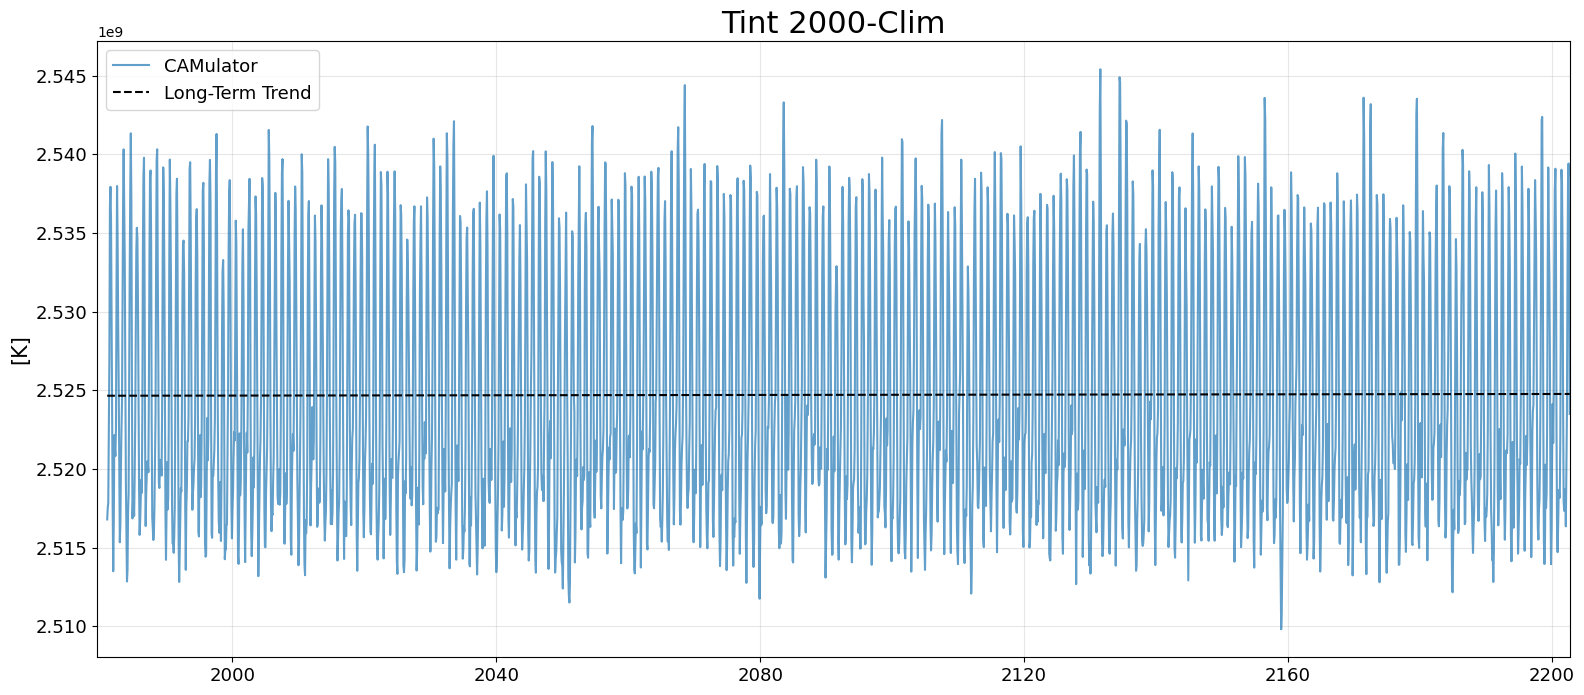

In [20]:


import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from scipy.stats import linregress

# Define selected 30-year periods
start_years = [1981, 2011, 2041, 2071, 2111]  # Evenly spaced 30-year segments
periods = [(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year+31}-12-31")) for year in start_years]

# Extract the selected time periods
selected_times = np.concatenate([MA_TWP_weighted_month['time'].sel(time=slice(start, end)).values for start, end in periods])
selected_values = np.concatenate([MA_TWP_weighted_month.sel(time=slice(start, end)).values for start, end in periods])

# Compute the trend over the whole period
start_years = [1981, 2011, 2041, 2071]  # Evenly spaced 30-year segments
periods = [(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year+30}-12-31")) for year in start_years]

time = MA_TWP_weighted_month['time'].to_index()[10:]
slope, intercept, _, _, _ = linregress(time.map(pd.Timestamp.toordinal), 1004*(MA_TWP_weighted_month[10:].values/9.81))
trend_line = intercept + slope * time.map(pd.Timestamp.toordinal)

# Plotting
fig, ax = plt.subplots(figsize=(19, 8))

# Plot selected time periods
ax.plot(MA_TWP_weighted_month['time'][10:], 1004*(MA_TWP_weighted_month[10:].values/9.81), label="CAMulator", color="tab:blue", alpha=0.7)

# Plot trend over full dataset
ax.plot(MA_TWP_weighted_month['time'][10:], trend_line, color="black", linestyle="--", label="Long-Term Trend")

# # Indicate time gaps with vertical dashed lines
# for end in start_years:  # Skip last since there's no gap after it
#     ax.axvline(end, color="gray", linestyle="dashed", alpha=0.6)

ax.grid(True, alpha =0.3)
# Labels and title
ax.set_ylabel("[K]", fontsize=15)
ax.set_title("Tint 2000-Clim",fontsize=22)
ax.tick_params(axis='x', labelsize=13)  # Adjust x-axis tick label size
ax.tick_params(axis='y', labelsize=13)  # Optionally adjust y-axis tick label size
ax.legend(fontsize=13)
plt.xlim([3455,85000])
plt.show()


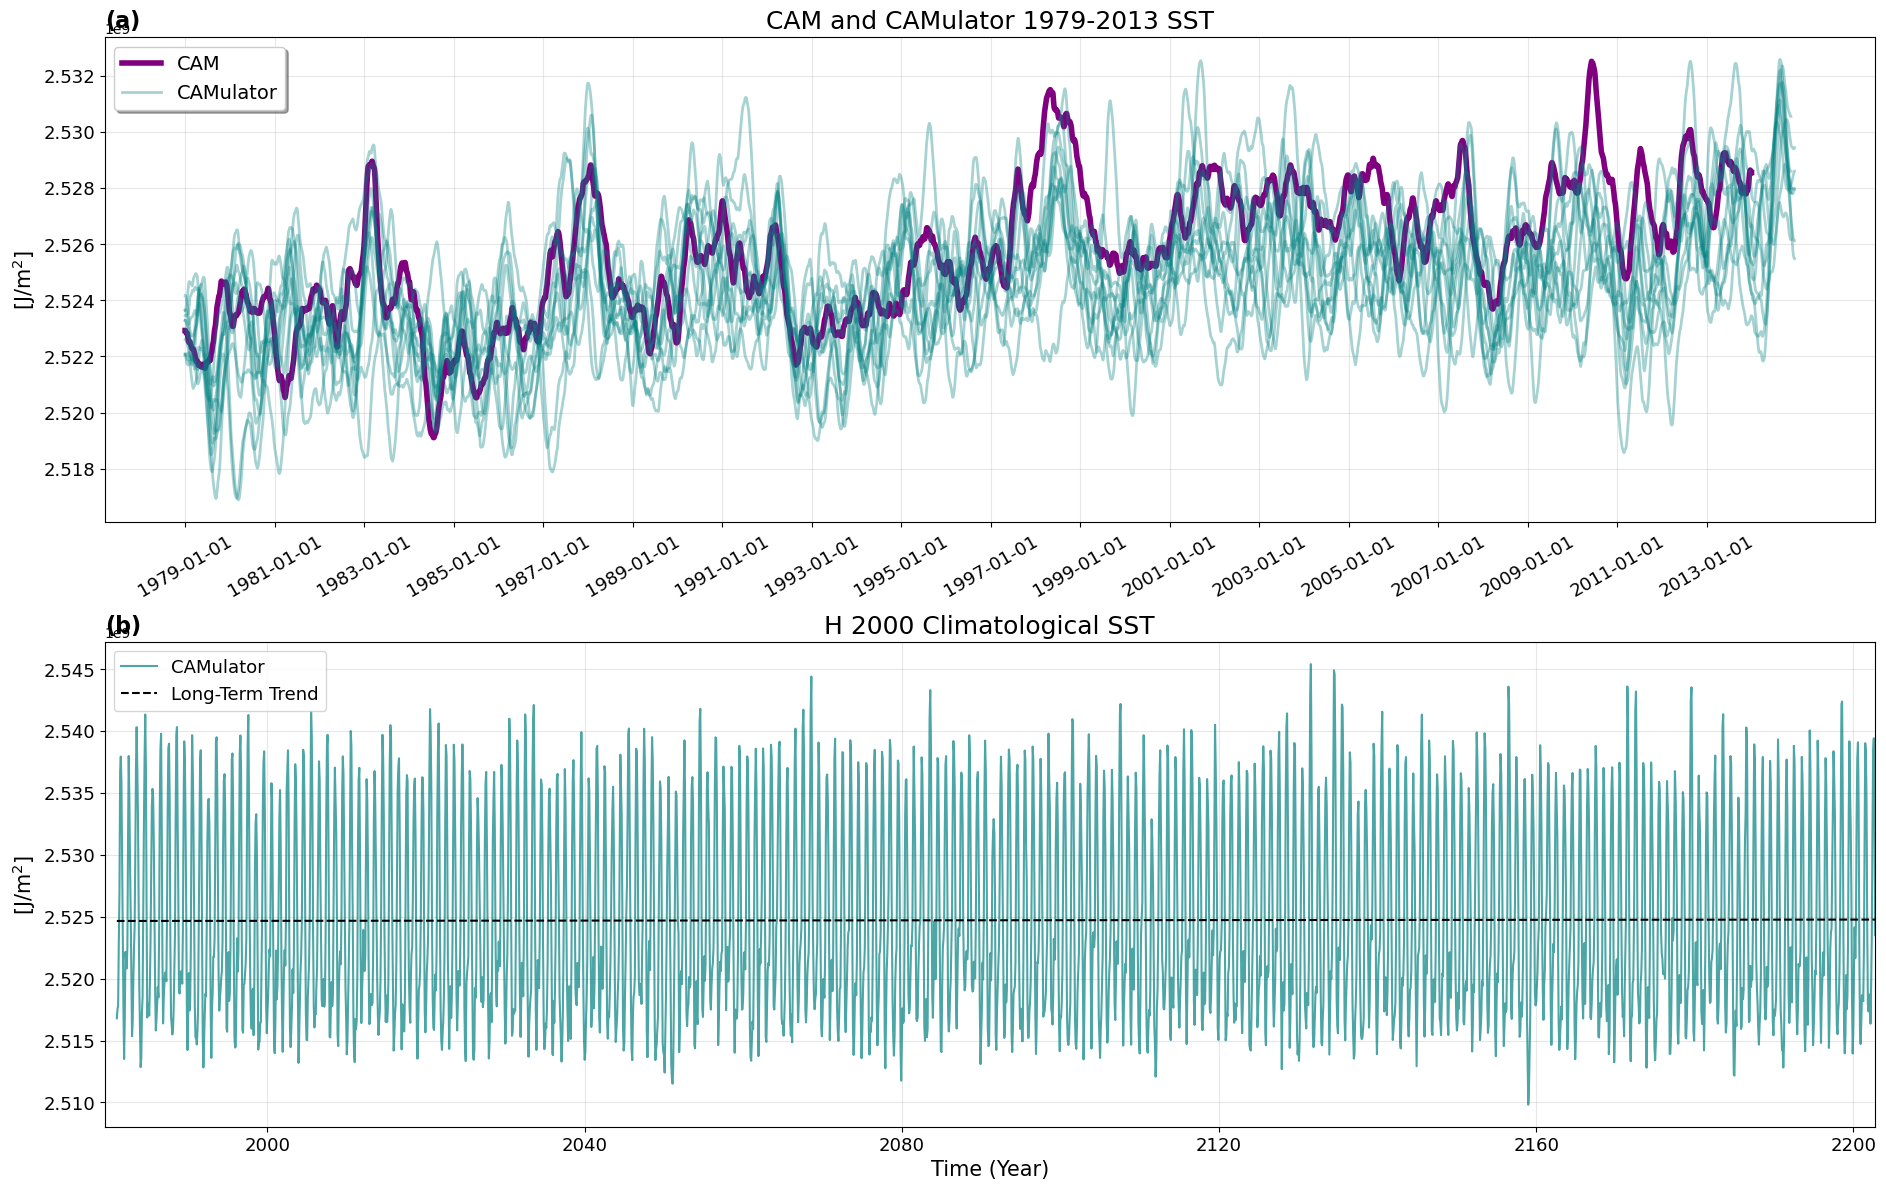

In [22]:
# Creating a stacked figure with two panels
# Convert cftime to datetime
# Convert cftime or numpy.datetime64 to pandas timestamps
time_converted = [pd.Timestamp(t).strftime('%Y-%m-%d') for t in TWP_camulator01['time'].values]

# Extract indices for January 1 of each year
year_ticks = [i for i, t in enumerate(TWP_camulator01['time'].values) if pd.Timestamp(t).month == 1 and pd.Timestamp(t).day == 1]

fig, axes = plt.subplots(nrows=2, figsize=(19, 12), sharex=False, gridspec_kw={'height_ratios': [1, 1]})

# Panel 1: Smoothed CAM and CAMulator Data
ax1 = axes[0]

time = TWP_camulator02.mean('ensemble_member_label')['time'].to_index()[:]
slope, intercept, _, _, _ = linregress(time.map(pd.Timestamp.toordinal),(1004*(TWP_camulator02.mean('ensemble_member_label')['__xarray_dataarray_variable__'].values)/9.81))
trend_line_EM = intercept + slope * time.map(pd.Timestamp.toordinal)

# ax1.plot(trend_line_EM, color="teal", linestyle="--", linewidth=4)

# Convert CFTimeIndex to standard datetime64
time_cftime = TWP_cam['time'].values  # Extracts cftime objects
time_datetime = np.array([pd.Timestamp(t.strftime('%Y-%m-%d')) for t in time_cftime])  # Converts to pandas timestamps

# Convert to ordinal numbers for regression
time_ordinal = np.array([t.toordinal() for t in time_datetime])

# Perform regression on the converted time
slope_cam, intercept, _, _, _ = linregress(time_ordinal, 1004*(TWP_cam['__xarray_dataarray_variable__'].values/9.81))

# Compute trend line
trend_line_CAM = intercept + slope_cam * time_ordinal
# ax1.plot( trend_line_CAM, color="purple", linestyle="--", linewidth=4)


ax1.plot(smooth_1d_array(1004*(TWP_cam['__xarray_dataarray_variable__'].values/9.81), 90), label='CAM', color='purple', linewidth=4)

ax1.plot(smooth_1d_array(1004*(TWP_camulator01['__xarray_dataarray_variable__'].values.T[:,0]/9.81), 90), label='CAMulator', color='teal', linewidth=2, alpha=0.35)

for ii in range(1,6):
    ax1.plot(smooth_1d_array(1004*(TWP_camulator01['__xarray_dataarray_variable__'].values.T[:, ii]/9.81), 90), color='teal', linewidth=2, alpha=0.35)
    ax1.plot(smooth_1d_array(1004*(TWP_camulator02['__xarray_dataarray_variable__'].values.T[:, ii]/9.81), 90), color='teal', linewidth=2, alpha=0.35)


# x-axis adjustments
ax1.set_ylabel("[J/m$^2$]", fontsize=15)
ax1.legend(loc='upper left', fontsize=14, frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.3)
ax1.set_title("CAM and CAMulator 1979-2013 SST", fontsize=18)

# Customize x-axis ticks to show years
ax1.set_xticks(
    year_ticks[::2],
    [time_converted[i] for i in year_ticks][::2],
    rotation=30,
    fontsize=13  # Smaller font size for clarity
)
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
ax1.text(0.0, 1.02, "(a)", transform=ax1.transAxes, fontsize=16, fontweight="bold")

time = MA_TWP_weighted_month['time'].to_index()[10:]
slope, intercept, _, _, _ = linregress(time.map(pd.Timestamp.toordinal), 1004*(MA_TWP_weighted_month[10:].values/9.81))
trend_line_cam = intercept + slope * time.map(pd.Timestamp.toordinal)

# Panel 2: Weighted Monthly Global Mean Temperature
ax2 = axes[1]
ax2.plot(MA_TWP_weighted_month['time'][10:],1004*(MA_TWP_weighted_month[10:]/9.81), label="CAMulator", color="teal", alpha=0.7)
ax2.plot(MA_TWP_weighted_month['time'][10:], trend_line_cam, color="black", linestyle="--", label="Long-Term Trend")

ax2.set_xlabel("Time (Year)", fontsize=15)
ax2.set_ylabel("[J/m$^2$]", fontsize=15)
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
ax2.set_xlim([3455, 85000])  # Matching x-axis range
ax2.legend(loc='upper left', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.set_title("H 2000 Climatological SST", fontsize=18)
ax2.text(0.0, 1.02, "(b)", transform=ax2.transAxes, fontsize=16, fontweight="bold")


# Show the figure
plt.tight_layout()
plt.savefig('H_Trend_Static.png',dpi=250, bbox_inches='tight')
plt.show()


## Q Total Water Path

In [7]:
model_level_file = '/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.statics_1.0deg_32levs_latlon_F32_hyai.nc'
DSml = xr.open_dataset(model_level_file)
print('starting')
# Define time chunk size
time_chunk = 1000
num_time_points = len(DSzarr1_TP['time'])
all_results = []

# Loop over time chunks
for start in range(0, num_time_points, time_chunk):
    end = min(start + time_chunk, num_time_points)
    print(f'Processing time points {start} to {end}')

    Qint_chunk = pressure_integral_midpoint_slice(
        DSzarr1_TP['Qtot'].isel(time=slice(start, end)),
        DSzarr1_TP['PS'].isel(time=slice(start, end)),
        DSml['hyai'],
        DSml['hybi'],
        sl_h=0,
        sl_l=1000
    )

    all_results.append(Qint_chunk)

# Concatenate all chunks along the time dimension
Qint_final = xr.concat(all_results, dim='time')

print('Processing complete')

# Compute weighted mean
weights = np.cos(np.deg2rad(Qint_final['latitude']))
weights /= weights.sum()
weighted_Qint_final = Qint_final.weighted(weights).mean(['longitude', 'latitude'])

print('Weighted mean computation complete')
weighted_Qint_final.to_netcdf('./TWP_cam_1979_2014.nc')

starting
Processing time points 0 to 1000
Processing time points 1000 to 2000
Processing time points 2000 to 3000
Processing time points 3000 to 4000
Processing time points 4000 to 5000
Processing time points 5000 to 6000
Processing time points 6000 to 7000
Processing time points 7000 to 8000
Processing time points 8000 to 9000
Processing time points 9000 to 10000
Processing time points 10000 to 11000
Processing time points 11000 to 12000
Processing time points 12000 to 12775
Processing complete
Weighted mean computation complete


## Ensemble

### Ensembles:

In [35]:
%%time
# Load dataset
model_level_file = '/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.statics_1.0deg_32levs_latlon_F32_hyai.nc'
DSml = xr.open_dataset(model_level_file)

print('Starting processing ensembles in chunks')

# Define time chunk size
time_chunk = 1500
ensemble_labels = Dens_01['ensemble_member_label'].values  # Get ensemble labels
all_ensemble_results = []

for ens in ensemble_labels:
    print(f'Processing ensemble {ens}')
    num_time_points = len(Dens_01['time'])
    all_results = []

    # Process chunks for each ensemble
    for start in range(0, num_time_points, time_chunk):
        end = min(start + time_chunk, num_time_points)
        print(f'Processing time points {start} to {end} for ensemble {ens}')

        # Load a single ensemble and the time chunk into memory
        BB = Dens_01.sel(ensemble_member_label=ens).isel(time=slice(start, end)).load()
        print('Loaded chunk')

        # Compute integral
        Qint_chunk = pressure_integral_midpoint_slice(
            BB['Qtot'],
            BB['PS'],
            DSml['hyai'],
            DSml['hybi'],
            sl_h=0,
            sl_l=1000
        )

        all_results.append(Qint_chunk.load())

    # Concatenate all chunks for the current ensemble
    Qint_final_ens = xr.concat(all_results, dim='time')
    all_ensemble_results.append(Qint_final_ens)

    print(f'Finished processing ensemble {ens}')

# Concatenate all ensemble results
Qint_final_all_ens = xr.concat(all_ensemble_results, dim='ensemble_member_label')

print('Processing complete for all ensembles')

# Compute weighted mean
weights = np.cos(np.deg2rad(Qint_final_all_ens['latitude']))
weights /= weights.sum()
weighted_Qint_final_all_ens = Qint_final_all_ens.weighted(weights).mean(['longitude', 'latitude'])

print('Weighted mean computation complete')
weighted_Qint_final_all_ens = weighted_Qint_final_all_ens.load()
weighted_Qint_final_all_ens.to_netcdf('./TWP_camulator_ensemble_1979_2014_01.nc')


Starting processing ensembles in chunks
Processing ensemble 0
Processing time points 0 to 1500 for ensemble 0
Loaded chunk
Processing time points 1500 to 3000 for ensemble 0
Loaded chunk
Processing time points 3000 to 4500 for ensemble 0
Loaded chunk
Processing time points 4500 to 6000 for ensemble 0
Loaded chunk
Processing time points 6000 to 7500 for ensemble 0
Loaded chunk
Processing time points 7500 to 9000 for ensemble 0
Loaded chunk
Processing time points 9000 to 10500 for ensemble 0
Loaded chunk
Processing time points 10500 to 12000 for ensemble 0
Loaded chunk
Processing time points 12000 to 12441 for ensemble 0
Loaded chunk
Finished processing ensemble 0
Processing ensemble 1
Processing time points 0 to 1500 for ensemble 1
Loaded chunk
Processing time points 1500 to 3000 for ensemble 1
Loaded chunk
Processing time points 3000 to 4500 for ensemble 1
Loaded chunk
Processing time points 4500 to 6000 for ensemble 1
Loaded chunk
Processing time points 6000 to 7500 for ensemble 1
Loa

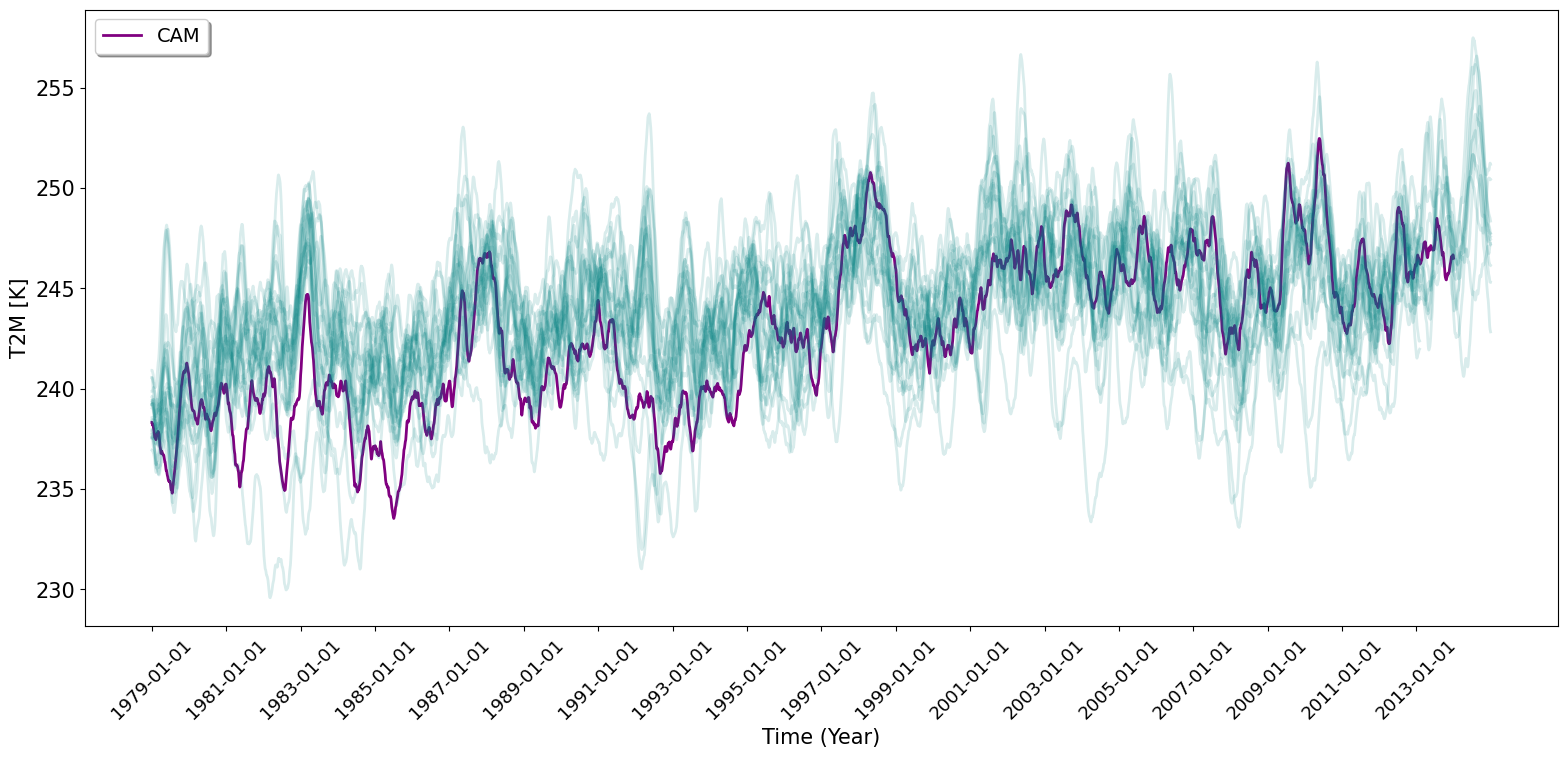

In [39]:
import matplotlib.pyplot as plt

weighted_Qint_final_all_ens_01 = xr.open_dataset('./TWP_camulator_ensemble_1979_2014_01.nc')
weighted_Qint_final_all_ens_02 = xr.open_dataset('./TWP_camulator_ensemble_1979_2014_02.nc')
weighted_Qint_final = xr.open_dataset('./TWP_cam_1979_2014.nc')

TWP_cam = remove_annual_harmonics(weighted_Qint_final, leap_year=False)
TWP_camulator01 = remove_annual_harmonics(weighted_Qint_final_all_ens_01, leap_year=False)
TWP_camulator02 = remove_annual_harmonics(weighted_Qint_final_all_ens_02, leap_year=False)


# Convert cftime to datetime
time_converted = [t.strftime('%Y-%m-%d') for t in weighted_Qint_final['time'].values]

# Extract indices for January 1 of each year
year_ticks = [i for i, t in enumerate(weighted_Qint_final['time'].values) if t.month == 1 and t.day == 1]

# Create the plot
plt.figure(figsize=(19, 8))  # Larger figure for better visibility


plt.plot(smooth_1d_array(TWP_cam['__xarray_dataarray_variable__'].values, 90),label='CAM',
    color='purple',
    linewidth=2
)

for ii in range(12):
    plt.plot(smooth_1d_array(TWP_camulator02['__xarray_dataarray_variable__'].values.T[:,ii], 90),
        color='teal',
        linewidth=2, alpha=0.15
    )


for ii in range(12):
    plt.plot(smooth_1d_array(TWP_camulator01['__xarray_dataarray_variable__'].values.T[:,ii], 90),
        color='teal',
        linewidth=2, alpha=0.15
    )

# Customize x-axis ticks to show years
plt.xticks(
    year_ticks[::2],
    [time_converted[i] for i in year_ticks][::2],
    rotation=45,
    fontsize=13  # Smaller font size for clarity
)
plt.yticks(fontsize=15)


# Adjust x-axis limits and labels
# plt.xlim([0, 5110])  # Limit the x-axis range
plt.xlabel("Time (Year)", fontsize=15)
plt.ylabel("T2M [K]", fontsize=15)

# Add legend with improved styling
plt.legend(
    loc='upper left',
    fontsize=14,
    frameon=True,
    fancybox=True,
    shadow=True
)
plt.show()

## MA Total Water path

In [20]:
%%time

base_dir = '/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/'
FNS1 = sorted(glob.glob(f"{base_dir}/monthly/1980-01-01T00Z/pred*.nc"))
FNS2 = sorted(glob.glob(f"{base_dir}/monthly_01/2102-01-01T00Z/pred*.nc"))
FNS = (FNS1+FNS2)

## here we go: 
DS2 = xr.open_mfdataset(FNS2[:-5], parallel=True)
DS1 = xr.open_mfdataset(FNS1[2:], parallel=True)
DS2['time'] = DS2['time'].astype('datetime64[ns]') - np.timedelta64(365, 'D')
DS1['time'] = DS1['time'].astype('datetime64[ns]')
DS = xr.concat([DS1,DS2],dim='time')

MA_Qint_chunk = pressure_integral_midpoint_slice(
        DS['Qtot'],
        DS['PS'],
        DSml['hyai'],
        DSml['hybi'],
        sl_h=0,
        sl_l=1000
    )

# Calculate latitude weights (cosine of latitude in radians)
weights = np.cos(np.deg2rad(DS['latitude']))

# Normalize weights to sum to 1
weights /= weights.sum()
weights = weights.load()

# Apply latitude weighting to the mean
MA_TWP_weighted_month = (MA_Qint_chunk
                      .weighted(weights)
                      .mean(['longitude', 'latitude']))
MA_TWP_weighted_month.load()

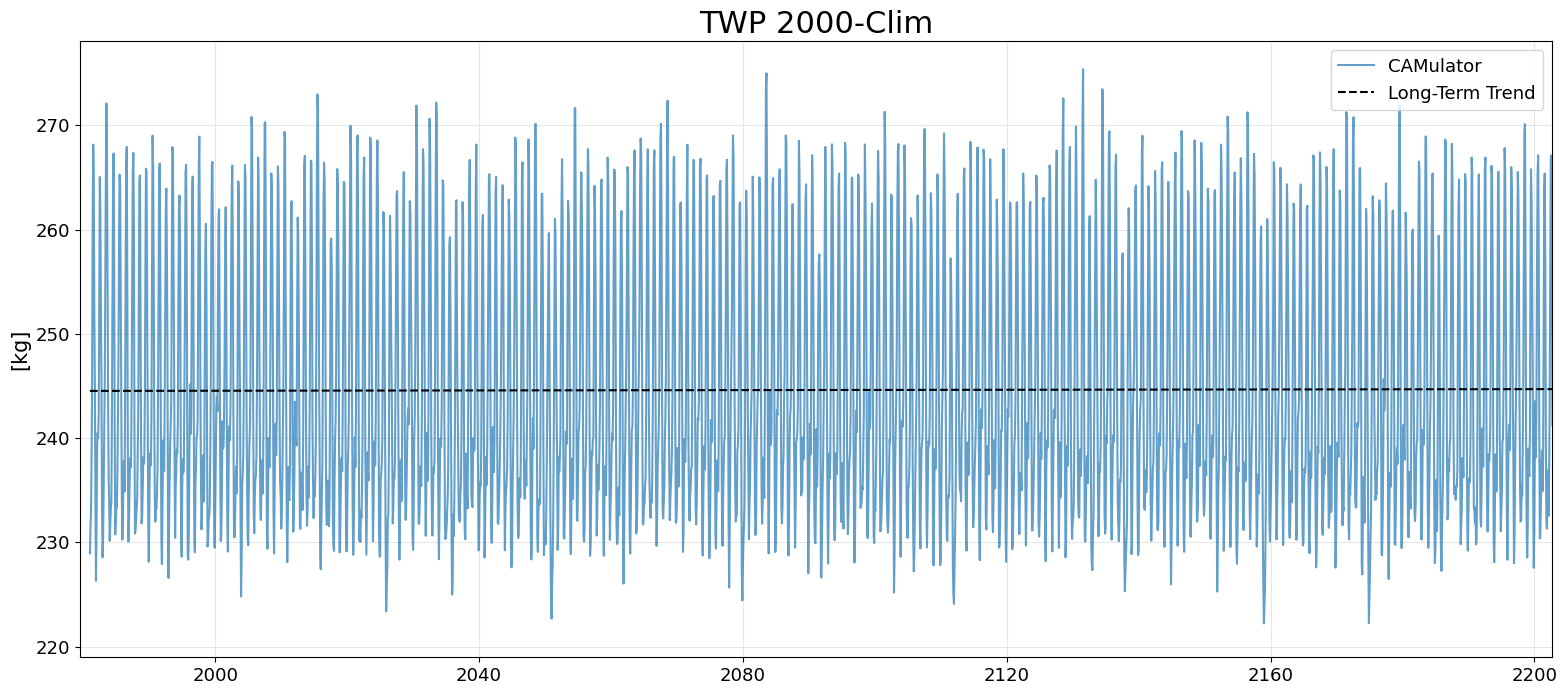

In [33]:


import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from scipy.stats import linregress

# Define selected 30-year periods
start_years = [1981, 2011, 2041, 2071, 2111]  # Evenly spaced 30-year segments
periods = [(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year+31}-12-31")) for year in start_years]

# Extract the selected time periods
selected_times = np.concatenate([MA_TWP_weighted_month['time'].sel(time=slice(start, end)).values for start, end in periods])
selected_values = np.concatenate([MA_TWP_weighted_month.sel(time=slice(start, end)).values for start, end in periods])

# Compute the trend over the whole period
start_years = [1981, 2011, 2041, 2071]  # Evenly spaced 30-year segments
periods = [(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year+30}-12-31")) for year in start_years]

time = MA_TWP_weighted_month['time'].to_index()[10:]
slope, intercept, _, _, _ = linregress(time.map(pd.Timestamp.toordinal), MA_TWP_weighted_month[10:].values)
trend_line = intercept + slope * time.map(pd.Timestamp.toordinal)

# Plotting
fig, ax = plt.subplots(figsize=(19, 8))

# Plot selected time periods
ax.plot(MA_TWP_weighted_month['time'][10:], MA_TWP_weighted_month[10:], label="CAMulator", color="tab:blue", alpha=0.7)

# Plot trend over full dataset
ax.plot(MA_TWP_weighted_month['time'][10:], trend_line, color="black", linestyle="--", label="Long-Term Trend")

# # Indicate time gaps with vertical dashed lines
# for end in start_years:  # Skip last since there's no gap after it
#     ax.axvline(end, color="gray", linestyle="dashed", alpha=0.6)

ax.grid(True, alpha =0.3)
# Labels and title
ax.set_ylabel("[kg]", fontsize=15)
ax.set_title("TWP 2000-Clim",fontsize=22)
ax.tick_params(axis='x', labelsize=13)  # Adjust x-axis tick label size
ax.tick_params(axis='y', labelsize=13)  # Optionally adjust y-axis tick label size
ax.legend(fontsize=13)
plt.xlim([3455,85000])
plt.show()


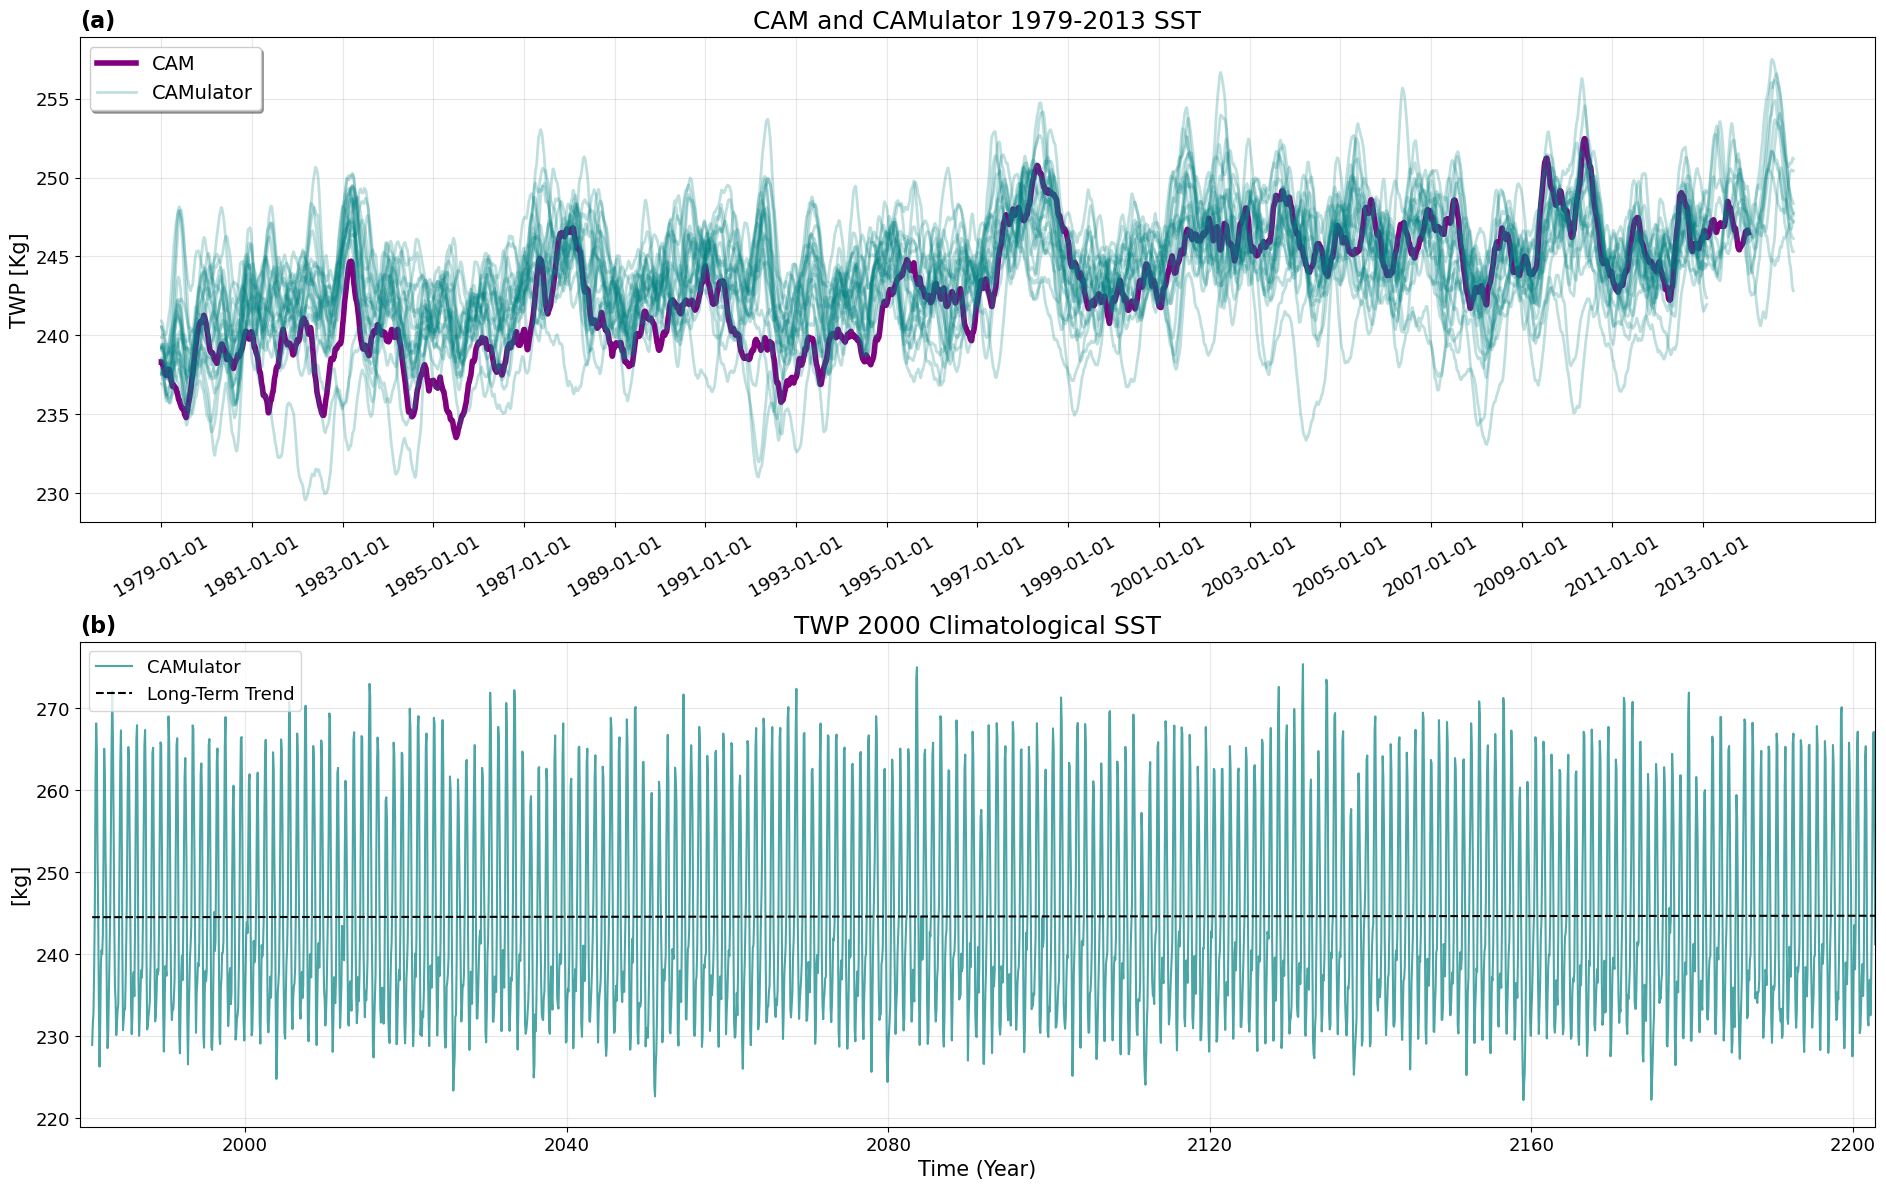

In [108]:
# Creating a stacked figure with two panels
# Convert cftime to datetime
# Convert cftime or numpy.datetime64 to pandas timestamps
time_converted = [pd.Timestamp(t).strftime('%Y-%m-%d') for t in TWP_camulator01['time'].values]

# Extract indices for January 1 of each year
year_ticks = [i for i, t in enumerate(TWP_camulator01['time'].values) if pd.Timestamp(t).month == 1 and pd.Timestamp(t).day == 1]

fig, axes = plt.subplots(nrows=2, figsize=(19, 12), sharex=False, gridspec_kw={'height_ratios': [1, 1]})

# Panel 1: Smoothed CAM and CAMulator Data
ax1 = axes[0]

time = TWP_camulator02.mean('ensemble_member_label')['time'].to_index()[:]
slope, intercept, _, _, _ = linregress(time.map(pd.Timestamp.toordinal),TWP_camulator02.mean('ensemble_member_label')['__xarray_dataarray_variable__'].values)
trend_line_EM = intercept + slope * time.map(pd.Timestamp.toordinal)

# ax1.plot(trend_line_EM, color="teal", linestyle="--", linewidth=4)

# Convert CFTimeIndex to standard datetime64
time_cftime = TWP_cam['time'].values  # Extracts cftime objects
time_datetime = np.array([pd.Timestamp(t.strftime('%Y-%m-%d')) for t in time_cftime])  # Converts to pandas timestamps

# Convert to ordinal numbers for regression
time_ordinal = np.array([t.toordinal() for t in time_datetime])

# Perform regression on the converted time
slope_cam, intercept, _, _, _ = linregress(time_ordinal, TWP_cam['__xarray_dataarray_variable__'].values)

# Compute trend line
trend_line_CAM = intercept + slope_cam * time_ordinal
# ax1.plot( trend_line_CAM, color="purple", linestyle="--", linewidth=4)


ax1.plot(smooth_1d_array(TWP_cam['__xarray_dataarray_variable__'].values, 90), label='CAM', color='purple', linewidth=4)

ax1.plot(smooth_1d_array(TWP_camulator01['__xarray_dataarray_variable__'].values.T[:,0], 90), label='CAMulator', color='teal', linewidth=2, alpha=0.25)

for ii in range(1,12):
    ax1.plot(smooth_1d_array(TWP_camulator01['__xarray_dataarray_variable__'].values.T[:, ii], 90), color='teal', linewidth=2, alpha=0.25)
    ax1.plot(smooth_1d_array(TWP_camulator02['__xarray_dataarray_variable__'].values.T[:, ii], 90), color='teal', linewidth=2, alpha=0.25)


# x-axis adjustments
ax1.set_ylabel("TWP [Kg]", fontsize=15)
ax1.legend(loc='upper left', fontsize=14, frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.3)
ax1.set_title("CAM and CAMulator 1979-2013 SST", fontsize=18)

# Customize x-axis ticks to show years
ax1.set_xticks(
    year_ticks[::2],
    [time_converted[i] for i in year_ticks][::2],
    rotation=30,
    fontsize=13  # Smaller font size for clarity
)
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
ax1.text(0.0, 1.02, "(a)", transform=ax1.transAxes, fontsize=16, fontweight="bold")

time = MA_TWP_weighted_month['time'].to_index()[10:]
slope, intercept, _, _, _ = linregress(time.map(pd.Timestamp.toordinal), MA_TWP_weighted_month[10:].values)
trend_line_cam = intercept + slope * time.map(pd.Timestamp.toordinal)

# Panel 2: Weighted Monthly Global Mean Temperature
ax2 = axes[1]
ax2.plot(MA_TWP_weighted_month['time'][10:],MA_TWP_weighted_month[10:], label="CAMulator", color="teal", alpha=0.7)
ax2.plot(MA_TWP_weighted_month['time'][10:], trend_line_cam, color="black", linestyle="--", label="Long-Term Trend")

ax2.set_xlabel("Time (Year)", fontsize=15)
ax2.set_ylabel("[kg]", fontsize=15)
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
ax2.set_xlim([3455, 85000])  # Matching x-axis range
ax2.legend(loc='upper left', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.set_title("TWP 2000 Climatological SST", fontsize=18)
ax2.text(0.0, 1.02, "(b)", transform=ax2.transAxes, fontsize=16, fontweight="bold")


# Show the figure
plt.tight_layout()
plt.savefig('TWP_Trend_Static.png',dpi=250, bbox_inches='tight')
plt.show()
